# Preprocess Signals from Vowels, Syllables and Sentences
Exract the voice signal sequence based on where voice activities start and end.

In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import scipy.io as sio
import numpy as np
import pandas as pd
from utils.vad import VAD
from python_speech_features import mfcc

## Load Voice
Load one normal vowels (/a/ normal, /u/ normal, /i/ normal) but only using voice channels, the normal vowels are used for fitting the Hidden Markov Model, generate all hidden state distributions.

In [2]:
# Select Subject and Vowel
subject = "R031"
vowel = "a_normal"

In [3]:
# Extract variables that contain related data
vowel_data = sio.loadmat('Data/%s/%s.mat' % (subject, vowel))
noise_data = sio.loadmat('Data/%s/noise.mat' % subject)

# Load all raw data values for vowels
Tmp_Data = vowel_data['data']
Start = vowel_data['datastart']
End = vowel_data['dataend']
Sample_Rate = vowel_data['samplerate']
rep = Start.shape[1]
sample_rate = int(Sample_Rate[4,0])
print("Load Voice: %s" % vowel)
print("Total Repetitions: %d" % rep)
print("Sampling Rate: %d" % sample_rate)

Load Voice: a_normal
Total Repetitions: 55
Sampling Rate: 20000


## Voice Activation Detection and Extraction
### To Do
Fix the VAD algorithm so that it could detect voice activation even when the voice starts at the beginning

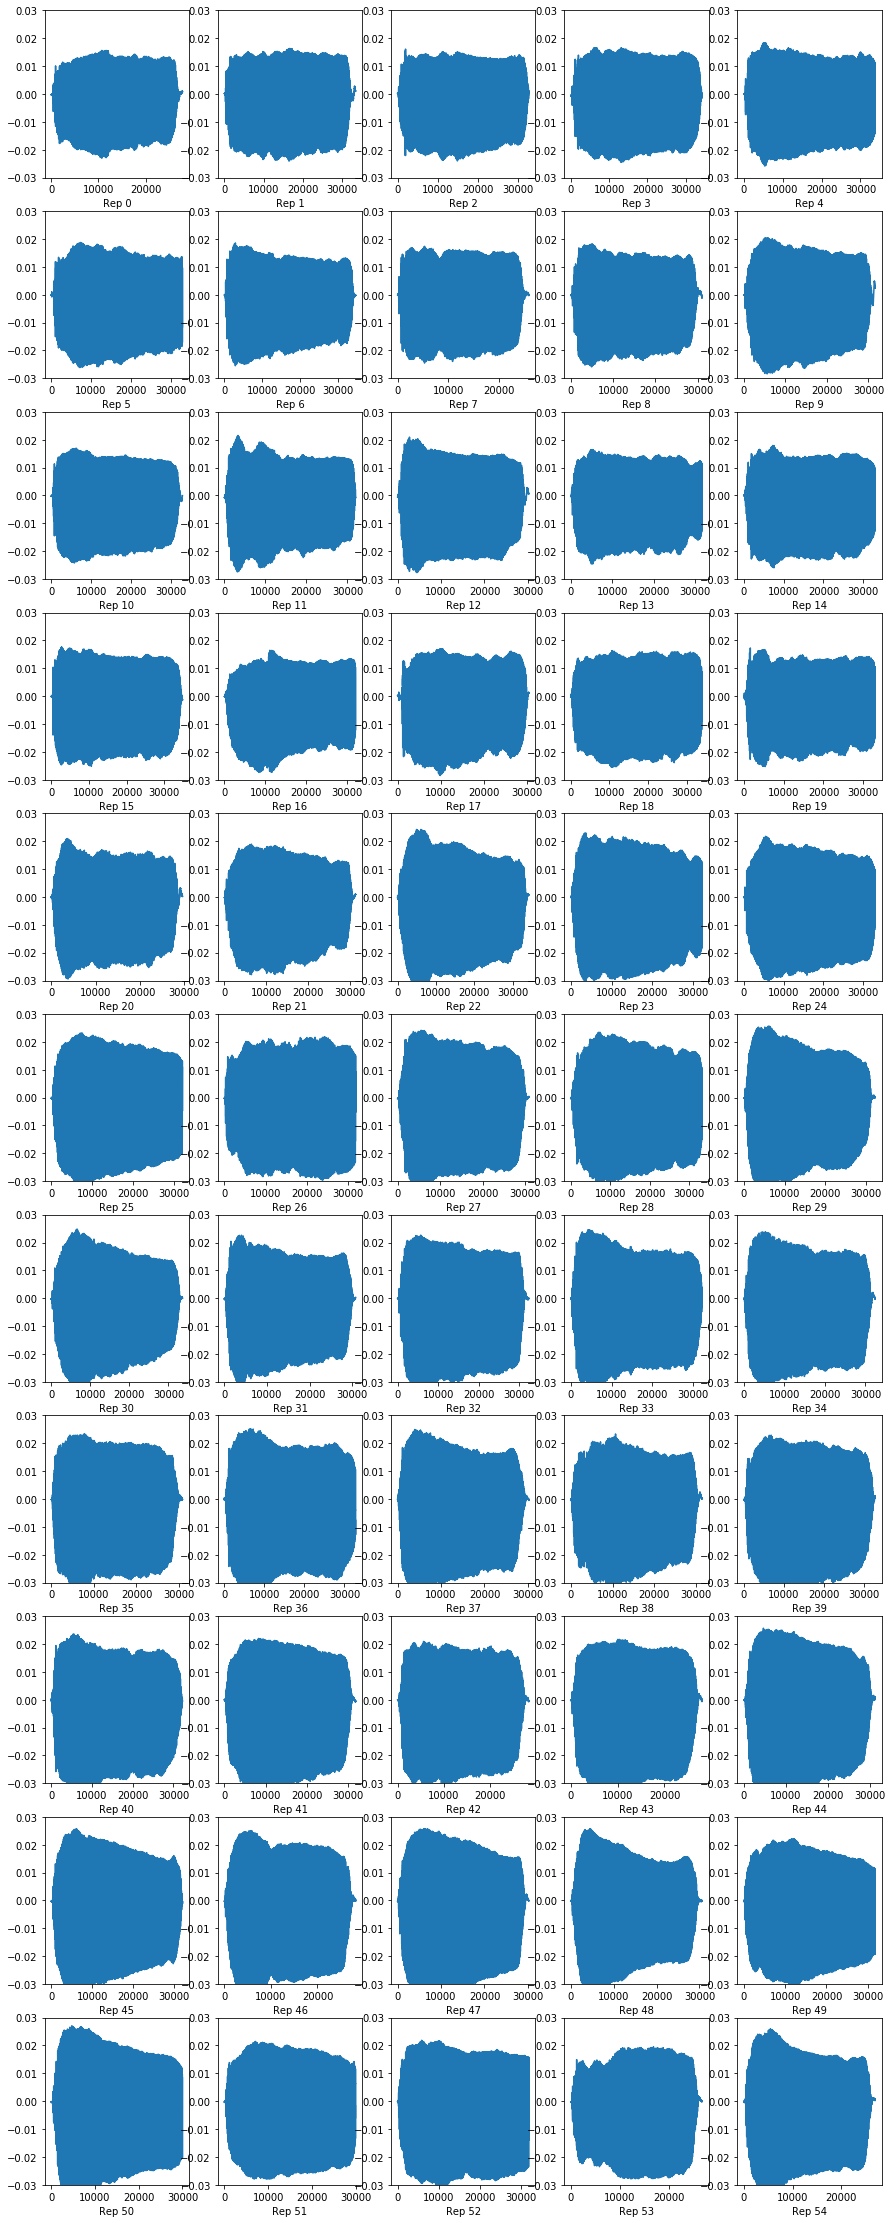

In [6]:
# Extract features from all 55 rep of voice signals
vowel_signal = []    # extracted raw signals
sr = []          # the length for individual signals
thr = 0.99

plt.figure(figsize=(15, 40))
for rep in range(55):
    # ----- Extract the 2 channels voice signal -----
    voice_sample_channel = np.zeros((2*sample_rate, 2))
    
    # For the left channel
    # Get the indices for the current repetiton
    voice_start = int(Start[4,rep]) - 1
    voice_end = int(End[4,rep])
    # Extract and center the current voice signal
    voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
    voice_sample_channel[:,0] = voice_sample_tmp - np.mean(voice_sample_tmp)

    # For the right channel
    # Get the indices for the current repetiton
    voice_start = int(Start[5,rep]) - 1
    voice_end = int(End[5,rep])
    # Extract and center the current voice signal
    voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
    voice_sample_channel[:,1] = voice_sample_tmp - np.mean(voice_sample_tmp)

    # Combine from sterero into mono
#     voice_sample = voice_sample_channel[:,0]    # in case one of the channel
                                                  # collected signal with bad
                                                  # quality
    
    voice_sample = np.mean(voice_sample_channel, axis=1, 
                           dtype=voice_sample_channel.dtype)
    
    # ----- Detect voice activation -----
    # in case the data collection went extremely well
#     i_start = 0
#     i_end   = 39999
    
    # manually injuect noise at the beginning of the signals
#     if rep == 46:
#         voice_sample = np.append(voice_sample[range(38000,39000)], 
#                              voice_sample)

    vad = VAD(voice_sample, sample_rate, 
              nFFT=512, win_length=0.025, 
              hop_length=0.01, theshold=thr)

    vad_post = vad.reshape(-1)
    vad_post = np.append([0], vad_post)
    vad_post = np.append(vad_post, [0])

    # peform the differentiation
    vad_detect = np.diff(vad_post)

    # Eliminate potential voice noise
    vad_start = []
    vad_end   = []
    # find non-zero elements +1/-1
    for i, v in enumerate(vad_detect):
        if v == 1:
            vad_start.append(i)
        elif v == -1:
            vad_end.append(i)

    # measure the length of each activation
    vad_delete = []
    for i, (s, e) in enumerate(zip(vad_start, vad_end)):
        if e - s < 10:
            vad_delete.append(i)

    vad_start = np.delete(vad_start, vad_delete, 0)
    vad_end = np.delete(vad_end, vad_delete, 0)

    i_start = int((vad_start[0]*0.01)*sample_rate)
    i_end   = int((vad_end[0]*0.01+0.05)*sample_rate)   
    if i_end > 39999:
        i_end = 39999

    vowel_signal.append(voice_sample[range(i_start, i_end+1)])
    sr.append(sample_rate)        

    plt.subplot(11, 5, rep+1)
    plt.plot(voice_sample[range(i_start, i_end+1)])
    plt.xlabel("Rep %d" % rep)
    plt.ylim((-0.03, 0.03))

plt.show()

## Examine Individual Signals (Optional)
Potential issues from the raw 2 channel voice signals:
 - one channel could be distorted
 - signal could start too early which cause detection to fail

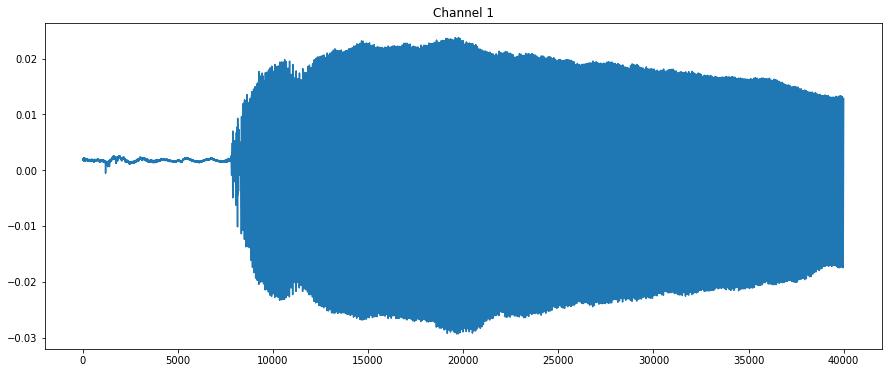

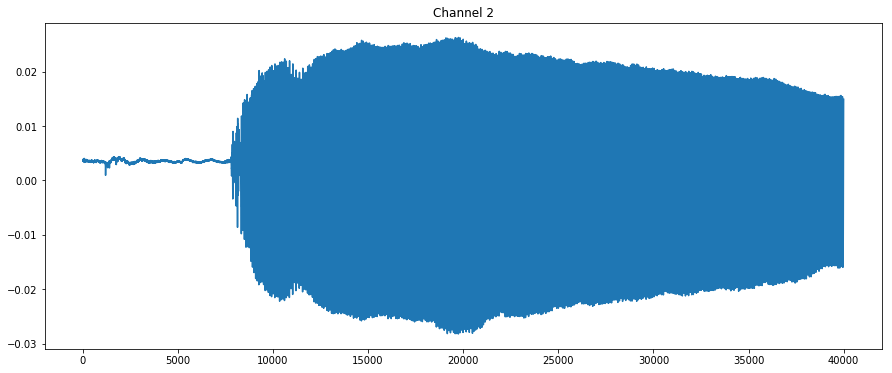

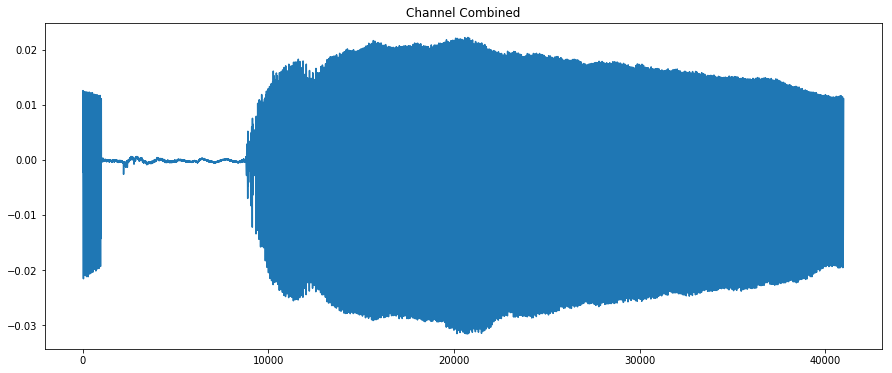

In [7]:
i = 49

# ----- Extract the 2 channels voice signal -----
voice_sample_channel = np.zeros((2*sample_rate, 2))

# For the left channel
# Get the indices for the current repetiton
voice_start = int(Start[4,i]) - 1
voice_end = int(End[4,i])
# Extract and center the current voice signal
voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
# voice_sample_channel[:,0] = voice_sample_tmp
voice_sample_channel[:,0] = voice_sample_tmp - np.mean(voice_sample_tmp)

plt.figure(figsize=(15, 6))
plt.plot(voice_sample_tmp)
plt.title("Channel 1")
plt.show()

# For the right channel
# Get the indices for the current repetiton
voice_start = int(Start[5,i]) - 1
voice_end = int(End[5,i])
# Extract and center the current voice signal
voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
# voice_sample_channel[:,1] = voice_sample_tmp
voice_sample_channel[:,1] = voice_sample_tmp - np.mean(voice_sample_tmp)

plt.figure(figsize=(15, 6))
plt.plot(voice_sample_tmp)
plt.title("Channel 2")
plt.show()

# Combine from sterero into mono
voice_sample = np.mean(voice_sample_channel, axis=1, 
                       dtype=voice_sample_channel.dtype)

voice_sample = np.append(voice_sample[range(38000,39000)], 
                         voice_sample)


plt.figure(figsize=(15, 6))
plt.plot(voice_sample)
plt.title("Channel Combined")
plt.show()

## Investigate Voice Activation Detection Failure (Optional)

In [ ]:
# Detect voice activations
vad=VAD(voice_sample, sample_rate, nFFT=512, win_length=0.025, hop_length=0.01, theshold=0.70)

print(sum(vad))

vad_post = vad.reshape(-1)
vad_post = np.append([0], vad_post)
vad_post = np.append(vad_post, [0])
print(vad_post)

# peform the differentiation
vad_detect = np.diff(vad_post)

# Eliminate potential voice noise
vad_start = []    # all start indices for the current state
vad_end   = []    # all end indices for the current state
# find non-zero elements +1/-1
for i, v in enumerate(vad_detect):
    if v == 1:
        vad_start.append(i)
    elif v == -1:
        vad_end.append(i)
    
print(vad_start, vad_end)

# measure the length of each activation
vad_delete = []
for i, (s, e) in enumerate(zip(vad_start, vad_end)):
    if e - s < 10:
        vad_delete.append(i)
    print(i)
    print(s, e)
print(vad_delete)

vad_start = np.delete(vad_start, vad_delete, 0)
vad_end = np.delete(vad_end, vad_delete, 0)

print(vad_start[0], vad_end[0])

i_start = int((vad_start[0]*0.01+0.02)*sample_rate)
i_end   = int((vad_end[0]*0.01+0.075)*sample_rate)
if i_end > 39999:
    i_end = 39999
        
print(i_start, i_end)

plt.figure(figsize=(15, 6))
plt.plot(voice_sample[range(i_start, i_end+1)])
plt.show()

## Save Final Pre-Processed Voices

In [8]:
extracted_voice = list(zip(vowel_signal, sr))

# save as .npy file
np.save('Data/%s/voice_%s.npy' % (subject, vowel), extracted_voice)

# save as .csv file
df = pd.DataFrame(data = extracted_voice, columns=['Signal', 'Rate'])
df.to_csv('Data/%s/voice_%s.csv' % (subject, vowel),index=False,header=True)